<a href="https://colab.research.google.com/github/maha2000/emotion-recognition/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras

# For the model
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet


# Loading models
from keras.models import load_model

# Image preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as kb

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Utilities
import h5py
import itertools

In [0]:
def plot_confusion_matrix(true, prediction, name):
    cm = confusion_matrix(true.argmax(1), prediction.argmax(1))
    cm = cm.astype('float') / cm.sum(axis=1)
    
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(7)
    plt.xticks(tick_marks, emotions, rotation=45)
    plt.yticks(tick_marks, emotions)
    
    thresh = cm.max()/1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name + ".jpg", dpi=300)

In [0]:
seed = 7
np.random.seed(seed)

In [0]:
emotions = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

In [0]:
X = np.load('/content/drive/My Drive/emotion-recognition/features.npy') # features
y = np.load('/content/drive/My Drive/emotion-recognition/labels.npy') # labels

In [109]:
X = X.reshape(X.shape[0], 48, 48)
X = np.expand_dims(X, axis=4)
y = np_utils.to_categorical(y, num_classes=7)
print(X.shape, y.shape)

(35887, 48, 48, 1) (35887, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


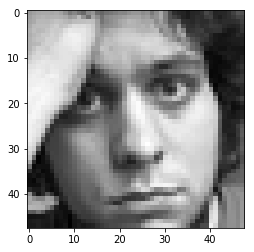

In [110]:
X_test = X[28709:]
X_train = X[:28709]
y_test = y[28709:]
y_train = y[:28709]
sample = X_train[500].reshape(48, 48)
plt.imshow(sample,interpolation=None,cmap='gray')

In [0]:
X_train_trial=np.zeros((28709,48,48,3))
X_test_trial=np.zeros((7178,48,48,3))

for i in range(len(X_train_trial)):
  X_train_trial[i] = np.stack((X_train[i].reshape(48,48),)*3, axis=-1)
for j in range(len(X_test_trial)):
  X_test_trial[j] = np.stack((X_test[j].reshape(48,48),)*3, axis=-1)

# Resnet50


In [115]:
# img_input = Input(shape=(48,48,1))
# img_conc = Concatenate()([img_input, img_input, img_input])
# model=ResNet50(include_top=False, weights='imagenet',input_tensor=img_conc,input_shape=(48,48,3))

model=ResNet50(include_top=False, weights='imagenet',input_shape=(48,48,3))
model.layers.pop()
for layer in model.layers:
  layer.trainable = False

x = model.output
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)) (x)
x = Dropout(0.5) (x)
predictions = Dense(7, activation='softmax', name='predictions')(x)

top_model = Model(inputs=model.input, outputs=predictions)


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
top_model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

In [117]:
 new_model = top_model.fit(X_train_trial, y_train, batch_size=96, epochs=10, verbose=1, validation_data=(X_test_trial, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 43s 1ms/step - loss: 2.8977 - acc: 0.3262 - val_loss: 2.4383 - val_acc: 0.3140
Epoch 2/10
28709/28709 [==============================] - 30s 1ms/step - loss: 2.2635 - acc: 0.3916 - val_loss: 2.6057 - val_acc: 0.2831
Epoch 3/10
28709/28709 [==============================] - 30s 1ms/step - loss: 2.2168 - acc: 0.3967 - val_loss: 2.4799 - val_acc: 0.2887
Epoch 4/10
28709/28709 [==============================] - 30s 1ms/step - loss: 2.2016 - acc: 0.3937 - val_loss: 2.4428 - val_acc: 0.3023
Epoch 5/10
28709/28709 [==============================] - 30s 1ms/step - loss: 2.1651 - acc: 0.3997 - val_loss: 2.3331 - val_acc: 0.3217
Epoch 6/10
28709/28709 [==============================] - 30s 1ms/step - loss: 2.1390 - acc: 0.4017 - val_loss: 2.4240 - val_acc: 0.3238
Epoch 7/10
28709/28709 [==============================] - 30s 1ms/step - loss: 2.1303 - acc: 0.3988 - val_loss: 2.6039 - val_acc:

In [119]:
scores = top_model.evaluate(X_test_trial, y_test)

7178/7178 [==============================] - 9s 1ms/step


In [120]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  32.864307607406026 %


In [0]:
top_model.save('resnet50_epoch10_bs96.h5')

In [153]:
y_test[0].shape

(7,)

In [158]:
y_pred=top_model.predict(X_test_trial,verbose=1)

7178/7178 [==============================] - 9s 1ms/step


In [156]:
y_pred[0]

array([0.10926208, 0.00780863, 0.30219272, 0.09809895, 0.02088534,
       0.41804957, 0.04370268], dtype=float32)

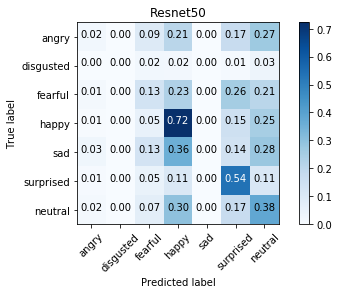

In [162]:
plot_confusion_matrix(y_test, y_pred, "Resnet50")

# VGG16

In [0]:
model=VGG16(include_top=False, weights='imagenet',input_shape=(48,48,3))
model.layers.pop() 
for layer in model.layers:
  layer.trainable = False

x = model.output
#x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)) (x)
x= Dropout(0.5) (x)
prediction = Dense(7, activation='softmax', name='predictions')(x)

top_model = Model(inputs=model.input, outputs=prediction)


In [0]:
top_model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

In [167]:
new_model = top_model.fit(X_train_trial, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_trial, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 34s 1ms/step - loss: 2.1967 - acc: 0.3242 - val_loss: 1.8713 - val_acc: 0.3915
Epoch 2/10
28709/28709 [==============================] - 22s 759us/step - loss: 1.8567 - acc: 0.3858 - val_loss: 1.7582 - val_acc: 0.4097
Epoch 3/10
28709/28709 [==============================] - 22s 760us/step - loss: 1.7548 - acc: 0.4060 - val_loss: 1.7126 - val_acc: 0.4276
Epoch 4/10
28709/28709 [==============================] - 22s 760us/step - loss: 1.7027 - acc: 0.4167 - val_loss: 1.6952 - val_acc: 0.4128
Epoch 5/10
28709/28709 [==============================] - 22s 754us/step - loss: 1.6805 - acc: 0.4213 - val_loss: 1.6743 - val_acc: 0.4224
Epoch 6/10
28709/28709 [==============================] - 22s 759us/step - loss: 1.6604 - acc: 0.4243 - val_loss: 1.6612 - val_acc: 0.4210
Epoch 7/10
28709/28709 [==============================] - 22s 761us/step - loss: 1.6504 - acc: 0.4273 - val_loss: 1.655

In [168]:
scores = top_model.evaluate(X_test_trial, y_test)

7178/7178 [==============================] - 7s 998us/step


In [169]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  42.54667038255231 %


In [0]:
top_model.save('vgg16_epoch10_bs128.h5')

In [171]:
y_pred=top_model.predict(X_test_trial,verbose=1)

7178/7178 [==============================] - 11s 2ms/step


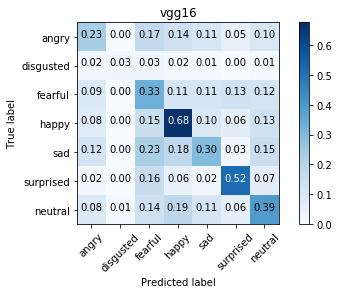

In [174]:
plot_confusion_matrix(y_test, y_pred, "vgg16")

# VGG19

In [0]:
model=VGG19(include_top=False, weights='imagenet',input_shape=(48,48,3))
model.layers.pop()
for layer in model.layers:
  layer.trainable = False

x = model.output
#x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)) (x)
x= Dropout(0.5) (x2)
predictions = Dense(7, activation='softmax', name='predictions')(x)

top_model = Model(inputs=model.input, outputs=predictions)
top_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [176]:
new_model = top_model.fit(X_train_trial, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_trial, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 38s 1ms/step - loss: 2.4332 - acc: 0.2849 - val_loss: 1.9375 - val_acc: 0.3760
Epoch 2/10
28709/28709 [==============================] - 26s 897us/step - loss: 1.9723 - acc: 0.3475 - val_loss: 1.8404 - val_acc: 0.3965
Epoch 3/10
28709/28709 [==============================] - 26s 900us/step - loss: 1.8616 - acc: 0.3700 - val_loss: 1.7725 - val_acc: 0.3994
Epoch 4/10
28709/28709 [==============================] - 26s 897us/step - loss: 1.8079 - acc: 0.3749 - val_loss: 1.7407 - val_acc: 0.4061
Epoch 5/10
28709/28709 [==============================] - 26s 898us/step - loss: 1.7774 - acc: 0.3804 - val_loss: 1.7293 - val_acc: 0.4012
Epoch 6/10
28709/28709 [==============================] - 26s 895us/step - loss: 1.7635 - acc: 0.3773 - val_loss: 1.7146 - val_acc: 0.3955
Epoch 7/10
28709/28709 [==============================] - 26s 896us/step - loss: 1.7548 - acc: 0.3786 - val_loss: 1.704

In [177]:
scores = top_model.evaluate(X_test_trial, y_test)

7178/7178 [==============================] - 8s 1ms/step


In [178]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  40.373363054605804 %


In [0]:
top_model.save('vgg19_epoch10_bs128.h5')

In [180]:
y_pred=top_model.predict(X_test_trial,verbose=1)

7178/7178 [==============================] - 13s 2ms/step


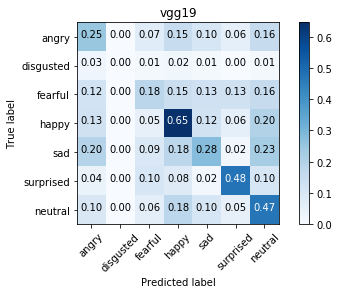

In [181]:
plot_confusion_matrix(y_test, y_pred, "vgg19")

# MobileNet

In [184]:
model=MobileNet(include_top=False, weights='imagenet',input_shape=(48,48,3))
model.layers.pop() 
for layer in model.layers:
  layer.trainable = False

x = model.output
#x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)) (x)
x= Dropout(0.5) (x)
prediction = Dense(7, activation='softmax', name='predictions')(x)

top_model = Model(inputs=model.input, outputs=prediction)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [186]:
top_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_model = top_model.fit(X_train_trial, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_trial, y_test))

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 23s 796us/step - loss: 2.5444 - acc: 0.3111 - val_loss: 2.3800 - val_acc: 0.2473
Epoch 2/10
28709/28709 [==============================] - 8s 296us/step - loss: 2.0187 - acc: 0.3594 - val_loss: 2.1559 - val_acc: 0.2471
Epoch 3/10
28709/28709 [==============================] - 9s 301us/step - loss: 1.8433 - acc: 0.3681 - val_loss: 2.0962 - val_acc: 0.2469
Epoch 4/10
28709/28709 [==============================] - 9s 300us/step - loss: 1.7837 - acc: 0.3682 - val_loss: 2.0757 - val_acc: 0.1718
Epoch 5/10
28709/28709 [==============================] - 9s 311us/step - loss: 1.7657 - acc: 0.3664 - val_loss: 2.0488 - val_acc: 0.2437
Epoch 6/10
28709/28709 [==============================] - 9s 302us/step - loss: 1.7586 - acc: 0.3654 - val_loss: 2.0594 - val_acc: 0.2471
Epoch 7/10
28709/28709 [==============================] - 9s 308us/step - loss: 1.7462 - acc: 0.3710 - val_loss: 1.9929 - 

In [187]:
scores = top_model.evaluate(X_test_trial, y_test)

7178/7178 [==============================] - 4s 503us/step


In [188]:
print("Accuracy: ", scores[1]*100, "%")

Accuracy:  14.265812205617292 %


In [0]:
top_model.save('mobilenet_epoch10_bs128.h5')

In [190]:
y_pred=top_model.predict(X_test_trial,verbose=1)

7178/7178 [==============================] - 9s 1ms/step


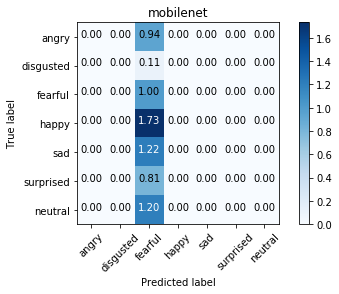

In [191]:
plot_confusion_matrix(y_test, y_pred, "mobilenet")